# K plus proches voisins (kNN)


## Note importante:

Dans ce cours, nous adoptons une approche délibérément pratique de l'algorithme kNN. Notre objectif principal n'est pas d'explorer en profondeur la théorie mathématique sous-jacente, mais plutôt de développer des compétences pratiques.

### Ce qui est attendu :
- Savoir interpréter chaque ligne de code et sa fonction  
- Être capable d'adapter le code à différentes situations pratiques  
- Maîtriser la préparation des données

### Ce qui n'est pas attendu :
- La démonstration mathématique de l'algorithme  
- Les détails théoriques avancés du fonctionnement interne  
- L'optimisation algorithmique  
- Les cas d'usage complexes  

### Focus du cours :
2. **Compréhension du code** : Que fait chaque ligne ?
3. **Utilisation concrète** : Comment l'appliquer à des cas réels ?

Concentrez-vous sur la compréhension pratique et l'application concrète.

---

Les codes que nous allons voir ensemble seront expliqués ligne par ligne. Ne vous inquiétez pas si la théorie sous-jacente semble complexe - concentrez-vous sur la compréhension pratique du code et son application.

## Introduction

L'algorithme des k plus proches voisins (kNN) est une méthode fondamentale en apprentissage automatique, particulièrement utile pour l'analyse statistique dans diverses applications comme :
- La classification des risques en assurance
- L'évaluation de la probabilité de réclamation
- La segmentation des clients

Dans ce chapitre, nous allons utiliser kNN pour prédire si un assuré va renouveler son contrat d'assurance-vie en fonction de diverses caractéristiques.

## 1. Configuration de l'environnement

Commençons par charger les bibliothèques nécessaires :

In [2]:
library(tidyverse)    # Pour la manipulation et visualisation des données
library(class)        # Pour l'algorithme kNN
library(caret)        # Pour l'évaluation du modèle
library(scales)       # Pour le formatage des échelles

# Définition d'une graine aléatoire pour la reproductibilité
set.seed(123)

## 2. Génération des données

Pour cet exemple, nous allons créer un jeu de données synthétiques qui simule des caractéristiques de clients d'assurance-vie.

In [3]:
n <- 1000  # nombre de clients

donnees <- tibble(
  age = runif(n, 25, 75),
  prime_annuelle = rlnorm(n, log(5000), 0.5),
  anciennete = rpois(n, 5),
  nb_reclamations = rpois(n, 0.5),
  valeur_contrat = rlnorm(n, log(100000), 0.7)
)

# Création de la variable cible (renouvellement)
donnees <- donnees %>%
  mutate(
    prob_renouvellement = 1 / (1 + exp(-(
      -2 +
      0.03 * (age - 50) +
      0.0001 * (prime_annuelle - 5000) +
      0.2 * anciennete +
      -0.5 * nb_reclamations +
      0.00001 * (valeur_contrat - 100000)
    ))),
    renouvellement = rbinom(n, 1, prob_renouvellement)
  ) %>%
  select(-prob_renouvellement)

# Affichage des premières lignes
head(donnees)

age      prime_annuelle anciennete nb_reclamations valeur_contrat
1 39.37888 3700.587       3          0                62178.22     
2 64.41526 3042.223       9          1               149483.96     
3 45.44885 8354.752       4          0                61069.34     
4 69.15087 7278.819       6          1                68812.22     
5 72.02336 2351.033       3          0               171956.13     
6 27.27782 4767.701       6          0                71681.68     
  renouvellement
1 1             
2 0             
3 0             
4 1             
5 0             
6 0

**Explication des variables :**
- `age` : Âge du client (25-75 ans)
- `prime_annuelle` : Prime annuelle payée par le client
- `anciennete` : Nombre d'années depuis la souscription initiale
- `nb_reclamations` : Nombre de réclamations dans l'année précédente
- `valeur_contrat` : Valeur totale du contrat
- `renouvellement` : Variable cible (1 = renouvelle, 0 = ne renouvelle pas)

## 3. Analyse exploratoire des données

Avant d'appliquer kNN, explorons nos données pour mieux comprendre les relations entre les variables.


In [6]:
summary(donnees)



      age        prime_annuelle    anciennete    nb_reclamations
 Min.   :25.02   Min.   : 1227   Min.   : 0.00   Min.   :0.000  
 1st Qu.:37.68   1st Qu.: 3544   1st Qu.: 3.00   1st Qu.:0.000  
 Median :49.50   Median : 5073   Median : 5.00   Median :0.000  
 Mean   :49.86   Mean   : 5707   Mean   : 5.03   Mean   :0.469  
 3rd Qu.:62.34   3rd Qu.: 6938   3rd Qu.: 7.00   3rd Qu.:1.000  
 Max.   :74.97   Max.   :27238   Max.   :14.00   Max.   :5.000  
 valeur_contrat    renouvellement 
 Min.   :  11188   Min.   :0.000  
 1st Qu.:  63906   1st Qu.:0.000  
 Median :  97291   Median :0.000  
 Mean   : 127887   Mean   :0.317  
 3rd Qu.: 160478   3rd Qu.:1.000  
 Max.   :1096563   Max.   :1.000  

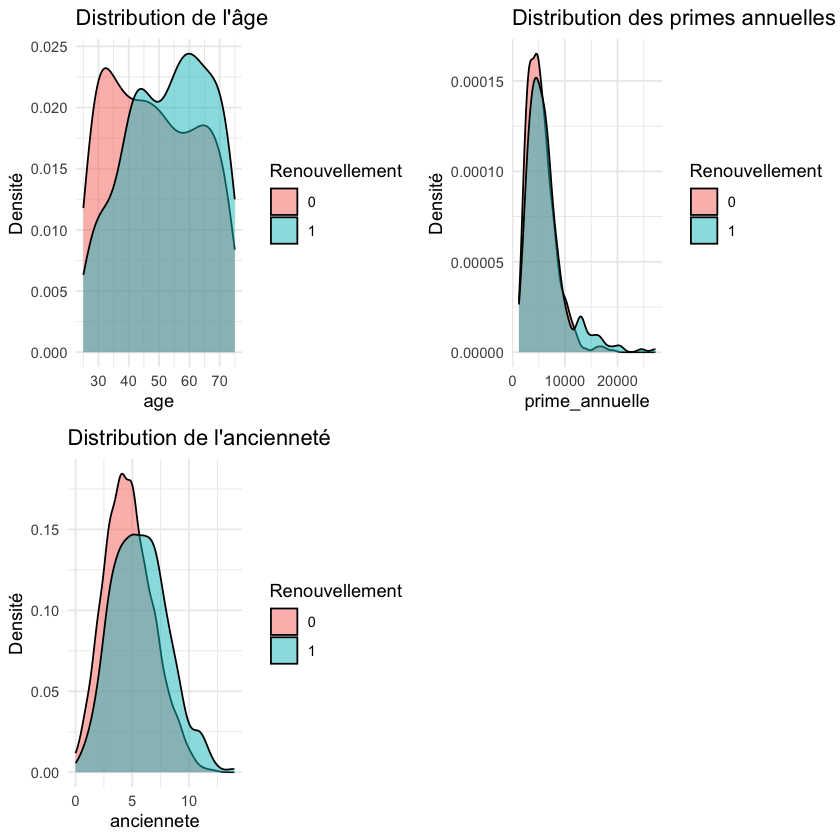

In [5]:
# Visualisation de la distribution des variables numériques par statut de renouvellement
plot_distribution <- function(data, var, titre) {
  ggplot(data, aes(x = !!sym(var), fill = factor(renouvellement))) +
    geom_density(alpha = 0.5) +
    labs(title = titre,
         x = var,
         y = "Densité",
         fill = "Renouvellement") +
    theme_minimal()
}

# Création des graphiques
p1 <- plot_distribution(donnees, "age", "Distribution de l'âge")
p2 <- plot_distribution(donnees, "prime_annuelle", "Distribution des primes annuelles")
p3 <- plot_distribution(donnees, "anciennete", "Distribution de l'ancienneté")

# Affichage des graphiques
gridExtra::grid.arrange(p1, p2, p3, ncol = 2)

**Explication :**
L'analyse exploratoire nous permet de :
1. Identifier les différences de distribution entre les clients qui renouvellent et ceux qui ne renouvellent pas
2. Détecter d'éventuelles valeurs aberrantes
3. Comprendre les relations entre les variables


## 4. Prétraitement des données

kNN est sensible à l'échelle des variables. Nous devons donc normaliser nos données.

In [7]:
# Fonction de normalisation
normaliser <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

# Application de la normalisation
donnees_norm <- donnees %>%
  mutate(across(-renouvellement, normaliser))

# Division en ensembles d'entraînement et de test
indices_train <- createDataPartition(donnees_norm$renouvellement, p = 0.8, list = FALSE)
train_data <- donnees_norm[indices_train, ]
test_data <- donnees_norm[-indices_train, ]

# Séparation des caractéristiques et de la variable cible
X_train <- train_data %>% select(-renouvellement) %>% as.matrix()
y_train <- train_data$renouvellement
X_test <- test_data %>% select(-renouvellement) %>% as.matrix()
y_test <- test_data$renouvellement

**Explication :**
- La normalisation met toutes les variables à la même échelle [0,1]
- Nous utilisons 80% des données pour l'entraînement et 20% pour le test
- Les données sont converties en matrices pour l'algorithme kNN


## 5. Application de l'algorithme kNN

Maintenant, appliquons l'algorithme kNN avec différentes valeurs de k pour trouver la meilleure configuration.



[1] "Valeur optimale de k: 23"


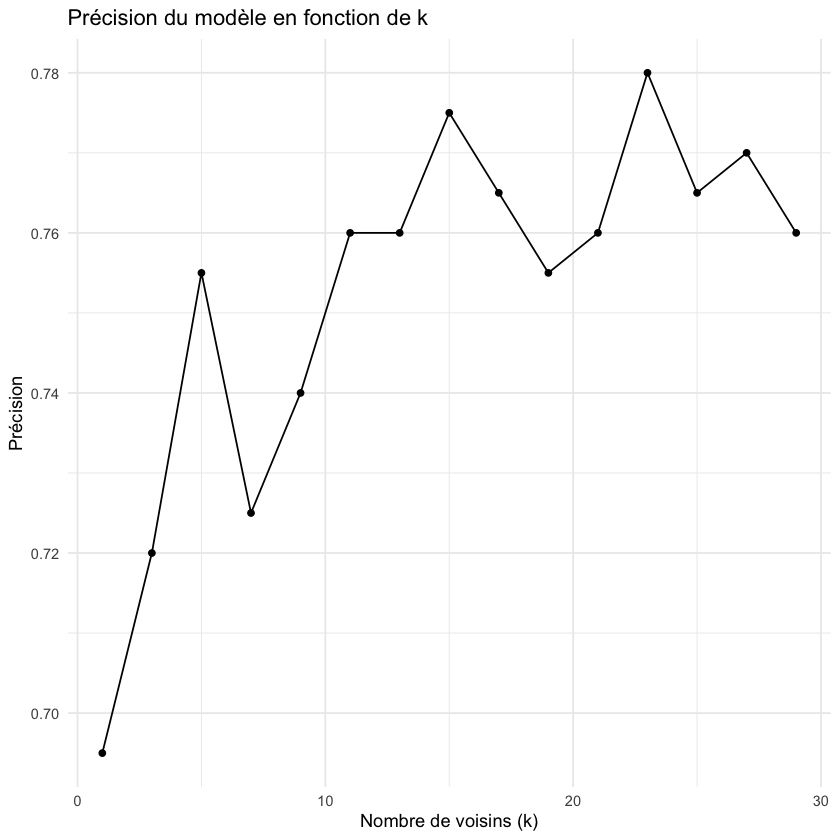

In [8]:
# Test de différentes valeurs de k
k_values <- seq(1, 30, by = 2)
accuracy <- numeric(length(k_values))

for(i in seq_along(k_values)) {
  predictions <- knn(train = X_train,
                    test = X_test,
                    cl = factor(y_train),
                    k = k_values[i])
  
  cm <- confusionMatrix(predictions, factor(y_test))
  accuracy[i] <- cm$overall["Accuracy"]
}

# Visualisation des résultats
resultats_k <- tibble(k = k_values, accuracy = accuracy)
ggplot(resultats_k, aes(x = k, y = accuracy)) +
  geom_line() +
  geom_point() +
  labs(title = "Précision du modèle en fonction de k",
       x = "Nombre de voisins (k)",
       y = "Précision") +
  theme_minimal()

# Sélection du meilleur k
k_optimal <- k_values[which.max(accuracy)]
print(paste("Valeur optimale de k:", k_optimal))


**Explication :**
- Nous testons différentes valeurs de k pour trouver celle qui donne les meilleures performances
- Un k trop petit peut conduire à du surapprentissage
- Un k trop grand peut perdre des patterns importants dans les données

## 6. Évaluation du modèle

Évaluons les performances du modèle avec la valeur optimale de k.

In [9]:
# Prédictions finales avec le k optimal
predictions_finales <- knn(train = X_train,
                         test = X_test,
                         cl = factor(y_train),
                         k = k_optimal)

# Matrice de confusion
cm_final <- confusionMatrix(predictions_finales, factor(y_test))
print(cm_final)

# Calcul des métriques importantes pour l'actuariat
metriques <- data.frame(
  Métrique = c("Précision", "Sensibilité", "Spécificité", "Valeur Prédictive Positive"),
  Valeur = c(
    cm_final$overall["Accuracy"],
    cm_final$byClass["Sensitivity"],
    cm_final$byClass["Specificity"],
    cm_final$byClass["Pos Pred Value"]
  )
)
print(metriques)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 139  42
         1   2  17
                                          
               Accuracy : 0.78            
                 95% CI : (0.7161, 0.8354)
    No Information Rate : 0.705           
    P-Value [Acc > NIR] : 0.01075         
                                          
                  Kappa : 0.3412          
                                          
 Mcnemar's Test P-Value : 4.116e-09       
                                          
            Sensitivity : 0.9858          
            Specificity : 0.2881          
         Pos Pred Value : 0.7680          
         Neg Pred Value : 0.8947          
             Prevalence : 0.7050          
         Detection Rate : 0.6950          
   Detection Prevalence : 0.9050          
      Balanced Accuracy : 0.6370          
                                          
       'Positive' Class : 0               
                              

**Explication des métriques :**
- Précision : Proportion totale de prédictions correctes
- Sensibilité : Capacité à identifier les vrais renouvellements
- Spécificité : Capacité à identifier les non-renouvellements
- Valeur Prédictive Positive : Probabilité qu'un client prédit comme renouvelant renouvelle effectivement


## 7. Application pratique

Utilisons notre modèle pour prédire le renouvellement pour de nouveaux clients.

In [10]:
# Fonction de prédiction pour un nouveau client
predire_renouvellement <- function(age, prime, anciennete, reclamations, valeur) {
  # Création du nouveau cas
  nouveau_client <- data.frame(
    age = age,
    prime_annuelle = prime,
    anciennete = anciennete,
    nb_reclamations = reclamations,
    valeur_contrat = valeur
  )
  
  # Normalisation des données du nouveau client
  nouveau_client_norm <- as.matrix(mapply(function(x, col) {
    (x - min(donnees[[col]])) / (max(donnees[[col]]) - min(donnees[[col]]))
  }, nouveau_client, names(nouveau_client)))
  
  # Prédiction
  prediction <- knn(train = X_train,
                   test = nouveau_client_norm,
                   cl = factor(y_train),
                   k = k_optimal)
  
  return(prediction)
}

# Exemple d'utilisation
nouveau_client <- predire_renouvellement(
  age = 45,
  prime = 6000,
  anciennete = 3,
  reclamations = 0,
  valeur = 120000
)

print(paste("Prédiction pour le nouveau client:", 
            ifelse(nouveau_client == 1, "Va renouveler", "Ne va pas renouveler")))

ERROR: Error in knn(train = X_train, test = nouveau_client_norm, cl = factor(y_train), : dims of 'test' and 'train' differ







## Conclusion

Dans ce cours, nous avons :
1. Préparé et exploré des données d'assurance-vie
2. Appliqué l'algorithme kNN pour prédire les renouvellements
3. Évalué les performances du modèle
4. Créé une fonction pratique pour prédire de nouveaux cas

Points importants pour les actuaires :
- kNN est simple mais efficace pour la classification
- La normalisation des données est cruciale
- Le choix de k impacte significativement les performances
- L'interprétation des résultats doit tenir compte du contexte métier

## Exercices suggérés

1. Modifiez le code pour tester d'autres méthodes de normalisation
2. Ajoutez de nouvelles variables pertinentes pour l'assurance-vie
3. Comparez les performances de kNN avec d'autres algorithmes (ex: régression logistique)\

## Très optionels 
5. Analysez l'impact de différentes métriques de distance
6. Créez une visualisation des k plus proches voisins pour un cas spécifique

